### Instrument code

#### Step 1. Installment of libraries

In [1]:
%pip install matplotlib
%pip install yfinance
%pip install pandas


  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8488 sha256=22a0baf738634f9fbf300b945f6eb435f897a95416b6869bf97a1298ae9f823d
  Stored in directory: c:\users\a\appdata\local\pip\cache\wheels\21\c9\66\b41c847de65c7985db52ec21d59996841598b8b0e93f2b9500
Successfully built multitasking
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.


Note: you may need to restart the kernel to use updated packages.


#### Step 2. Product database creation

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from numpy.matlib import repmat as rp
from matplotlib.pyplot import figure
from matplotlib.ticker import PercentFormatter

# simulate underlying dynamics by a separate Monte-Carlo function
    
def get_MC_simulations(underlyings, start, end, sims, T):
    
    und_data = yf.download(underlyings, start, end, progress = False)
    und_close = und_data['Close']

    S0 = und_close.iloc[-1]
    und_returns = und_close.pct_change()
    mean_returns = und_returns.mean()
    
    # dynamics in case there are several underlyings

    if len(underlyings) > 1:
        
        cov_returns = und_returns.cov()

        mean_matrix = np.full(shape = (T, len(underlyings)), fill_value = mean_returns).T
        market_sims = np.full(shape = (T, len(underlyings), sims), fill_value = 0.0)

        for i in range(sims):

            Z = np.random.normal(size = (T, len(underlyings)))
            L = np.linalg.cholesky(cov_returns)

            dailyReturns = mean_matrix + np.inner(L, Z)
            market_sims[:, :, i] = np.cumprod(dailyReturns.T + 1, axis = 0)
        
        market_sims = market_sims.transpose(1, 0, 2)
        
    # dynamics in case of only one underlying

    else:

        std_returns = und_returns.std()

        mean_string = np.full(shape = (T, ), fill_value = mean_returns)
        std_string = np.full(shape = (T, ), fill_value = std_returns)
        market_sims = np.full(shape = (T, sims), fill_value = 0.0)

        for i in range(sims):

            Z = np.random.normal(size = (T, ))
            dailyReturns = mean_string + np.multiply(Z, std_string)
            market_sims[:, i] = np.cumprod(dailyReturns + 1, axis = 0)

    return market_sims

# Plugging underlying data into the payoff profiles of different types of products

def Structured_product(
    Class, Type, Protection, Underlyings, Months, Coup_barrier_1, Coup_barrier_2, Coupon_1, Coupon_2, Coupons_freq, 
    Participation, Cap, Autocall_barrier, Stepdown, Autocall_value, End_barrier, Price, Purchase_price = None, Risk_free = 0.1072):

    if not(Autocall_barrier > 0):
        Autocall_barrier = 99999
        Autocall_value = 0

    if not(Cap > 0):
        Cap = 99999

    # setting time intervals for simulations & date parameters

    T_days = 365
    W_days = 246
    WT_ratio = W_days / T_days

    # As far as T has been calculated in total calendar days, 
    # while the calculations use trading days, we need to adjust this number
    # by the WT ratio. While this does not provide 100% accuracy
    # because the exact number of trading days is not known in advance, 
    # this is still a good approximation and makes calculations much easier.

    T = int(Months * 30.5 * WT_ratio)

    T1 = dt.datetime.now()
    T0 = T1 - dt.timedelta(days = 3000)
    sims = 10000
    
    # map coupon repayment dates in case of coupon product

    if Coupons_freq > 0:

        if Class == "OTC":
            coupons_list = np.linspace(0, T, int(Months / Coupons_freq) + 1)[1:]
            coupons_list = np.round(coupons_list, 0).astype(int)
        
        elif Class == "MKT":
            coupons_list = np.sort(np.arange(T, 0, -int(Coupons_freq * 30.5 * WT_ratio + 1)))

        else:
            return "There is a mistake #1"
    
    # get data from Monte-Carlo simulations

    MS_data = get_MC_simulations(Underlyings, T0, T1, sims, T)
    
    # Undelrying dynamics are equal to worst-of underlying at every time stamp if there are several underlyings

    if len(Underlyings) > 1:
        Asset = np.amin(MS_data, axis = 0)

    else:
        Asset = MS_data

    Final_prices = Asset[T - 1]
    Outcome_values = np.full(shape = (sims, ), fill_value = 0)
    
    # calculating returns (over the invested amount of money) of products dependent on their type

    if Type == "Type 1" or Type == "Type 3":

        Outcome_values = Outcome_values + np.minimum(np.maximum((Final_prices - 1) * Participation, 0), Cap)

    elif Type == "Type 2" or Type == "Type 4":

        Coupons_memory = np.full(shape = (sims, ), fill_value = 1)
        Autocall_cumulative = np.full(shape = (sims, ), fill_value = 0)

        for i in coupons_list:

            boolean = Asset[i - 1] < Coup_barrier_1
            Outcome_values = Outcome_values + np.multiply(np.multiply(
                np.logical_not(boolean), Coupons_memory), 
                np.logical_not(np.sign(Autocall_cumulative))) * Coupon_1
            
            if Coupon_2 > 0:
                
                boolean_multi = Asset[i - 1] > Coup_barrier_2
                Outcome_values += boolean_multi * (Coupon_2 - Coupon_1)

            Autocall_current = Asset[i - 1] > Autocall_barrier
            Autocall_current = Autocall_current * (T - i)
            Autocall_cumulative = np.maximum(Autocall_current, Autocall_cumulative)

            Coupons_memory = np.multiply(Coupons_memory, boolean) + 1

            if Stepdown > 0:
                Autocall_barrier = Autocall_barrier - Stepdown

        Outcome_values += (Autocall_cumulative / W_days) * Risk_free
        
        Final_prices = Asset[-1]

    # Calculating the amount repaid of the nominal at maturity dependent on the product type
        
    if Type == "Type 1":
        Outcome_values += np.minimum(np.maximum(1 + (Final_prices - 1) * Participation, Protection), 1)
        
    elif Type == "Type 2":
        Outcome_values += (Protection + (Final_prices > End_barrier) * (1 - Protection)) * np.logical_not(
            np.sign(Autocall_cumulative)) + np.sign(Autocall_cumulative) * Autocall_value

    elif Type == "Type 3":
        Outcome_values += (np.minimum(Final_prices, End_barrier) + (
            Final_prices > End_barrier) * (1 - End_barrier))

    elif Type == "Type 4":
        Outcome_values += (np.minimum(Final_prices, End_barrier) + (
            Final_prices > End_barrier) * (1 - End_barrier)) * np.logical_not(
                np.sign(Autocall_cumulative)) + np.sign(Autocall_cumulative) * Autocall_value

    else:
        return "There is a mistake #2"
    
    # Adjusting for product type (market-traded or OTC)

    if Class == "MKT":
        Outcome_values = Outcome_values / Purchase_price

    elif Class == "OTC":
        Outcome_values = Outcome_values / Price

    return Outcome_values

# reading product parameters from the database

def Product_reader(n, database):
    
    Product = database.iloc[n - 1]

    underlyings = np.array(
        [Product["Underlying 1"], Product["Underlying 2"], Product["Underlying 3"], 
        Product["Underlying 4"], Product["Underlying 5"], Product["Underlying 6"]])

    underlyings = np.array(np.delete(underlyings, np.where(underlyings == 'nan')))
    underlyings = underlyings.tolist()
    
    Outcomes = Structured_product(Class = Product["Class"], Price = Product["Price"],
        Type = Product["Type"], Protection = Product["Protection"], Underlyings = underlyings, 
        Months = Product["Month"], Stepdown = Product["Stepdown"], Coup_barrier_1 = Product["Coup_barrier_1"], 
        Coup_barrier_2 = Product["Coup_barrier_2"], Coupon_1 = Product["Coupon_1"], Coupon_2 = Product["Coupon_2"],
        Coupons_freq = Product["Coupons_freq"], Participation = Product["Participation"], Cap = Product["Cap"], 
        Autocall_barrier = Product["Autocall_barrier"], Autocall_value = Product["Autocall_value"], End_barrier = Product["End_barrier"])

    risk_free_RUB = 0.1072
    risk_free_USD = 0.0260
    risk_free_EUR = 0.0022
    FX_USDRUB_monthly = ((risk_free_RUB + 1) / (risk_free_USD + 1)) ** (1/12) - 1
    FX_EURRUB_monthly = ((risk_free_RUB + 1) / (risk_free_EUR + 1)) ** (1/12) - 1

    # adjusting for currency of the product
    
    if Product["Currency"] == "USD":
        Outcomes = Outcomes * ((1 + FX_USDRUB_monthly) ** Product["Month"])

    elif Product["Currency"] == "EUR":
        Outcomes = Outcomes * ((1 + FX_EURRUB_monthly) ** Product["Month"])

    VaR = max(1 - np.percentile(Outcomes, 5), 0)
    Er = np.average(Outcomes) - 1

    return (VaR, Er, Outcomes)

# defining the class of the product by risk level

def Interval(n, database):

    Borders_VaR = {"Extremely high" : 1.00, "Very high" : 0.50, "High": 0.33, "Average" : 0.20, "Low" : 0.10, "Very low" : 0.00}
    VaR = database.loc[n - 1, "VaR"]

    risk_group = "Very low"
    min_diff = np.inf

    for border in Borders_VaR:
        s = Borders_VaR.get(border) - VaR
        if s >= 0 and s < min_diff:
            min_diff = s
            risk_group = border

    return risk_group

# creating and modifyng the database

def Create_Database():

    Database = pd.read_excel('202204230_Data_v4.xlsx', sheet_name = "Data")

    for i in range(Database.shape[0]):

        tuple = Product_reader(i + 1, database = Database)
        Database.loc[i, "VaR"] = tuple[0]
        Database.loc[i, "Er"] = tuple[1]
        Database.loc[i, "Group"] = Interval(i + 1, Database)

    Database["Er Annualized"] = (1 + Database["Er"]) ** (12 / Database["Month"]) - 1
    Database["Er Monthly"] = (1 + Database["Er"]) ** (1 / Database["Month"]) - 1

    return Database
    
Database = Create_Database()

#### Step 3. Matching algorithm and questionnaire launch

Название: Купонный продукт Реальный сектор мультибарьер
Выпускающая организация: BCS
Тип: Купонный доход без защиты капитала
Валюта: USD
Срок до погашения, мес.: 36
Ожидаемая среднегодовая доходность (10 000 симуляций): 16.0%


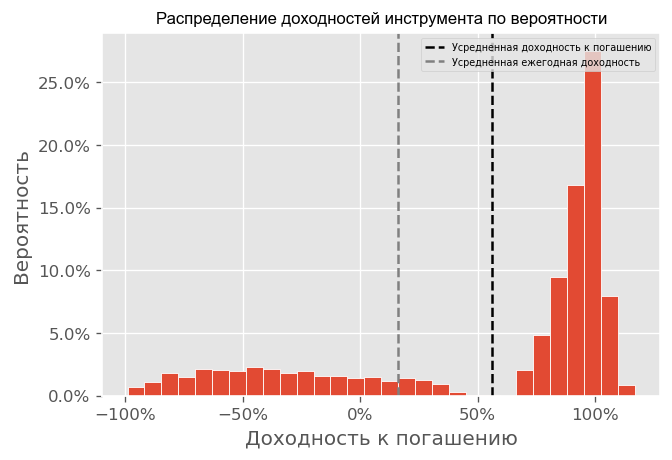

In [38]:
# Matching questionnaire response with products from thr database

def Matcher(Profile, timeframe):

    try:

        Choices1 = Database[Database.Group == Profile]
        if timeframe == 1:
            Choices2 = Choices1[Choices1.Month >= 12]
        elif timeframe == 0:
            Choices2 = Choices1[Choices1.Month < 12]
        choice = Choices2.iloc[np.argmax(Choices2["Er"])]
        
        if choice["Type"] == "Type 1":
            type_ = "Участие в росте с защитой капитала"
            
        elif choice["Type"] == "Type 2":
            type_ = "Купонный доход с защитой капитала"
            
        elif choice["Type"] == "Type 3":
            type_ = "Участие в росте без защиты капитала"
            
        elif choice["Type"] == "Type 4":
            type_ = "Купонный доход без защиты капитала"

        print("Название: " + choice["Name"])
        print("Выпускающая организация: " + choice["Bank"])
        print("Тип: " + type_)
        print("Валюта: " + choice["Currency"])
        print("Срок до погашения, мес.: " + str(choice["Month"]))
        print("Ожидаемая среднегодовая доходность (10 000 симуляций): " + '{:.1%}'.format(choice["Er Annualized"]))

        alpha = Product_reader(choice.Number, database = Database)[2]
        plt.figure(dpi = 120)
        plt.style.use("ggplot")
        plt.title("Распределение доходностей инструмента по вероятности", font = ("Arial"))
        plt.hist(alpha - 1, weights=np.ones(len(alpha)) / len(alpha), bins = 30, edgecolor = "white")
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
        plt.axvline(x = choice["Er"], color = 'black', ls = '--', label = 'Усредненная доходность к погашению')
        if choice["Month"] >= 12:
            plt.axvline(x = choice["Er Annualized"], color = 'grey', ls = '--', label = 'Усредненная ежегодная доходность')
        plt.xlabel('Доходность к погашению')
        plt.ylabel('Вероятность')
        plt.legend(loc = "upper right", fontsize = 'xx-small')
        plt.show()    
        
    except:
        print("К сожалению, в базе нет продуктов, соответствующих Вашему инвестиционному профилю. \nЗадумайтесь об инвестициях в другие финансовые инструменты")

import tkinter as tk
from tkinter import *
from tkinter import ttk
import ctypes
 
Fs = 9
num_questions = 13
ctypes.windll.shcore.SetProcessDpiAwareness(1)

# Determining investor's risk group dependend on his questionnaire response

def Risk_group(list_, timeframe):

    risk_score = sum(list_)

    Borders = {"Extremely high" : 43, "Very high" : 37, "High": 31, "Average" : 25, "Low" : 20, "Very low" : 0}

    risk_group = "not determined"
    min_diff = np.inf

    for border in Borders:
        s = risk_score - Borders.get(border)
        if s >= 0 and s < min_diff:
            min_diff = s
            risk_group = border

    Matcher(risk_group, timeframe)

# Gathering answers to questions via survey (questionnaire)
    
def Launcher():

    list_A = []
    TimeFrame = []

    window1 = tk.Tk()
    window1.attributes("-fullscreen", True)
    window1.title("Анкета риск-профилирования")
    title = tk.Label(font = ("Arial", 14, "bold"), fg = "Black", text = "Заполните анкету для определения оптимального структурного продукта").pack()
    questions = Canvas(window1)
    questions.pack()

    # Question 0

    q0 = tk.DoubleVar()
    E01 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n На какой срок Вы хотели бы инвестировать средства? \n").pack(anchor = "w")
    E02 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "До года", variable = q0, value = 0).pack(anchor = "w")
    E03 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "На год или больший срок", variable = q0, value = 1).pack(anchor = "w")

    # Question 1

    q1 = tk.DoubleVar()
    E1 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n 1. Как бы Ваш лучший друг описал Ваше отношение к риску? \n").pack(anchor = "w")
    E2 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Вы азартный игрок", variable = q1, value = 4).pack(anchor = "w")
    E3 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Вы готовы рисковать при проведении достаточного анализа рисков", variable = q1, value = 3).pack(anchor = "w")
    E4 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Вы очень осторожно относитесь к рискам", variable = q1, value = 2).pack(anchor = "w")
    E5 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Вы делаете все, чтобы избежать рисков", variable = q1, value = 1).pack(anchor = "w")

    # Question 2

    q2 = tk.DoubleVar()
    E6 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n 2. Представьте, что Вы участвуете в ТВ шоу и можете выбрать одну из опций ниже. Что Вы выберете? \n").pack(anchor = "w")
    E7 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "100 тысяч рублей гарантированно", variable = q2, value = 1).pack(anchor = "w")
    E8 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Шанс получить 500 тысяч рублей с вероятностью 50%", variable = q2, value = 2).pack(anchor = "w")
    E9 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Шанс получить 1 миллион рублей с вероятностью 25%", variable = q2, value = 3).pack(anchor = "w")
    E10 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Шанс получить 10 миллионов рублей с вероятностью 5%", variable = q2, value = 4).pack(anchor = "w")

    # Question 3

    q3 = tk.DoubleVar()
    E11 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n 3. Представьте, что Вы только что закончили копить на путешествие мечты. За три недели до вылета Вас увольняют с работы. Вы: \n").pack(anchor = "w")
    E12 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Отмените путешествие и вернете средства", variable = q3, value = 1).pack(anchor = "w")
    E13 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Измените путешествие на более скромное", variable = q3, value = 2).pack(anchor = "w")
    E14 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Поедете, как и планировали, так как Вам необходимо восстановиться и подготовиться к поиску работы", variable = q3, value = 3).pack(anchor = "w")
    E15 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Поедете в более роскошное путешествие, так как это может быть последняя такая возможность", variable = q3, value = 4).pack(anchor = "w")

    # Question 4

    q4 = tk.DoubleVar()
    E16 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n  4. Если бы Вы получили 2 миллиона рублей, которые необходимо инвестировать, что бы Вы предприняли? \n").pack(anchor = "w")
    E17 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Положить средства на депозит или инвестировать в валюту", variable = q4, value = 1).pack(anchor = "w")
    E18 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Вложить средства в высококачественные облигации", variable = q4, value = 2).pack(anchor = "w")
    E19 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Инвестировать в акции или ETF на акции", variable = q4, value = 3).pack(anchor = "w")

    frm_buttons = tk.Frame()
    frm_buttons.pack(fill = tk.X, ipadx = 5, ipady = 5)
    btn_submit = tk.Button(master=frm_buttons, text = "Далее", command = lambda:[window1.destroy(), TimeFrame.append(q0.get()), list_A.append(q1.get()), list_A.append(q2.get()), list_A.append(q3.get()), list_A.append(q4.get()), page_2(list_A, TimeFrame[0])])
    btn_submit.pack(side = tk.RIGHT, padx = 10, ipadx = 10)
    
    window1.mainloop()

def page_2(list_, timeframe):

    window2 = tk.Tk()
    window2.attributes("-fullscreen", True)
    window2.title("Анкета риск-профилирования")
    title = tk.Label(font = ("Arial", 14, "bold"), fg = "Dark Blue", text = "Заполните анкету для определения оптимального структурного продукта").pack()
    questions = Canvas(window2)
    questions.pack()

    # Question 5

    q5 = tk.DoubleVar()
    E20 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n  5. С точки зрения предыдущего опыта, насколько для Вас комфортны инвестиции в Акции или ETF? \n").pack(anchor = "w")
    E21 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Очень некомфортны", variable = q5, value = 1).pack(anchor = "w")
    E22 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Относительно комфортны", variable = q5, value = 2).pack(anchor = "w")
    E23 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Готов свободно инвестировать в акции и ETF", variable = q5, value = 3).pack(anchor = "w")

    # Question 6

    q6 = tk.DoubleVar()
    E24 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n  6. Какое из слов ниже более всего ассоциируется у Вас со словом риск? \n").pack(anchor = "w")
    E25 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Потеря", variable = q6, value = 1).pack(anchor = "w")
    E26 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Неопределенность", variable = q6, value = 2).pack(anchor = "w")
    E27 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Возможность", variable = q6, value = 3).pack(anchor = "w")
    E28 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Приятное волнение", variable = q6, value = 4).pack(anchor = "w")

    # Question 7

    q7 = tk.DoubleVar()
    E29 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n  7. Некоторые эксперты считают, что в ближайшее время цены золота, недвижимости и т.д. (фундаментальных активов) \n будут расти; цены гос. облигаций, напротив, могут упасть, однако эксперты считают, что это достаточно безопасная \n инвестиция. Большинство Ваших средств вложено в высокодоходные гос. облигации. Какими будут Ваши действия? ").pack(anchor = "w")
    E30 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Держать облигации", variable = q7, value = 1).pack(anchor = "w")
    E31 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Продать облигации: половину средств вложить в валюту, другую половину - в фундаментальные активы (золото, недвижимость и т.д)", variable = q7, value = 2).pack(anchor = "w")
    E32 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Продать облигации и вложить все средства в фундаментальные активы (золото, недвижимость и т.д)", variable = q7, value = 3).pack(anchor = "w")
    E33 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Продать облигации, занять больше средств и вложить все средства (свои и заемные) в фундаментальные активы (золото, недвижимость и т.д)", variable = q7, value = 4).pack(anchor = "w")

    # Question 8

    q8 = tk.DoubleVar()
    E34 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n  8. Исходя из представленных ниже худшего и лучшего сценариев инвестиций, какой вариант Вы выберете? \n").pack(anchor = "w")
    E35 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Доход 20 тысяч рублей в лучшем случае, без дохода - в худшем случае", variable = q8, value = 1).pack(anchor = "w")
    E36 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Доход 80 тысяч рублей в лучшем случае, потеря 20 тысяч рублей - в худшем случае", variable = q8, value = 2).pack(anchor = "w")
    E37 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Доход 260 тысяч рублей в лучшем случае, потеря 80 тысяч рублей - в худшем случае", variable = q8, value = 3).pack(anchor = "w")
    E38 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Доход 480 тысяч рублей в лучшем случае, потеря 240 тысяч рублей - в худшем случае", variable = q8, value = 4).pack(anchor = "w")

    # Question 9

    q9 = tk.DoubleVar()
    E39 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n  9. В дополнение к Вашему текущему состоянию, Вам дали 100 тысяч рублей и предложили сделать выбор. Какой из вариантов ниже Вы выберете? \n").pack(anchor = "w")
    E40 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Получить еще 50 тысяч рублей", variable = q9, value = 1).pack(anchor = "w")
    E41 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "С вероятностью 50% получить еще 100 тысяч рублей, с вероятнстью 50% - не получить больше ничего", variable = q9, value = 3).pack(anchor = "w")

    frm_buttons = tk.Frame()
    frm_buttons.pack(fill = tk.X, ipadx = 5, ipady = 5)
    btn_submit = tk.Button(master=frm_buttons, text = "Далее", command = lambda:[window2.destroy(), list_.append(q5.get()), list_.append(q6.get()), list_.append(q7.get()), list_.append(q8.get()), list_.append(q9.get()), page_3(list_, timeframe)])
    btn_submit.pack(side = tk.RIGHT, padx = 10, ipadx = 10)

    window2.mainloop()

def page_3(list_, timeframe):

    window3 = tk.Tk()
    window3.attributes("-fullscreen", True)
    window3.title("Анкета риск-профилирования")
    title = tk.Label(font = ("Arial", 14, "bold"), fg = "Dark Blue", text = "Заполните анкету для определения оптимального структурного продукта").pack()
    questions = Canvas(window3)
    questions.pack()

     # Question 10

    q10 = tk.DoubleVar()
    E42 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n  10. В дополнение к Вашему текущему состоянию, Вам дали 200 тысяч рублей и предложили сделать выбор. Какой из вариантов ниже Вы выберете? \n").pack(anchor = "w")
    E43 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Потерять 50 тысяч рублей из этой суммы", variable = q10, value = 1).pack(anchor = "w")
    E44 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "С вероятностью 50% потерять 100 тысяч рублей из этой суммы, с вероятностью 50% не потерять ничего", variable = q10, value = 3).pack(anchor = "w")

    # Question 11

    q11 = tk.DoubleVar()
    E45 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n  11. Представьте себе, что вы получаете в наследство 10 миллионов рублей при условии вложения средств в один\n из активов ниже. Какой вариант инвестиций Вы выберете? \n").pack(anchor = "w")
    E46 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Депозит или вложения в валюту", variable = q11, value = 1).pack(anchor = "w")
    E47 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Вложения в фонд, владеющий акциями и облигациями в соотношении 50/50", variable = q11, value = 2).pack(anchor = "w")
    E48 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Портфель из 15 обыкновенных акций компаний-голубых фишек", variable = q11, value = 3).pack(anchor = "w")
    E49 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Вложения в товарные фьючерсы на золото, серебро и нефть", variable = q11, value = 4).pack(anchor = "w")

    # Question 12

    q12 = tk.DoubleVar()
    E50 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n  12. Если бы Вам было необходимо инвестировать 2 миллиона рублей, какой вариант инвестирования показался бы Вам более привлекательным? \n").pack(anchor = "w")
    E51 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Вложить 60% в активы с низким риском, 30% со средним риском, 10% в высокорискованные активы", variable = q12, value = 1).pack(anchor = "w")
    E52 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Вложить 30% в активы с низким риском, 40% со средним риском, 30% в высокорискованные активы", variable = q12, value = 2).pack(anchor = "w")
    E53 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Вложить 10% в активы с низким риском, 40% со средним риском, 50% в высокорискованные активы", variable = q12, value = 3).pack(anchor = "w")

    # Question 13

    q13 = tk.DoubleVar()
    E54 = tk.Label(master = questions, font = ("Ariel", Fs, "bold"), text = "\n  13. Старый друг, которму Вы доверяете, эксперт в медиа и собирается сделать стартап. Если стартап окажется успешным, инвестиции \n вырастут в 50-100 раз; в ином случае они обесценятся. Друг оценивает шанс положительного исхода в 20%. \n Если бы у Вас были средства, сколько бы Вы вложили? \n").pack(anchor = "w")
    E55 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Не стал бы вкладывать средства", variable = q13, value = 1).pack(anchor = "w")
    E56 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Одну месячную зарплату", variable = q13, value = 2).pack(anchor = "w")
    E57 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Три месячных зарплаты", variable = q13, value = 3).pack(anchor = "w")
    E58 = tk.Radiobutton(master = questions, font = ("Ariel", Fs), text = "Полугодовую заплату", variable = q13, value = 4).pack(anchor = "w")

    frm_buttons = tk.Frame()
    frm_buttons.pack(fill = tk.X, ipadx = 5, ipady = 5)
    btn_submit = tk.Button(master=frm_buttons, text = "Отправить", command = lambda:[window3.destroy(), list_.append(q10.get()), list_.append(q11.get()), list_.append(q12.get()), list_.append(q13.get()), Risk_group(list_, timeframe)])
    btn_submit.pack(side = tk.RIGHT, padx = 10, ipadx = 10)

    window3.mainloop()

Launcher()